# Language Detection Using Natural Language Processing

This notebook implements a multilingual language detection model that can identify the language of text samples from 17 different languages using NLP techniques.

## Project Overview
- **Dataset**: Language Detection Dataset (17 languages)
- **Techniques**: Bag-of-Words, Label Encoding, Multinomial Naive Bayes
- **Goal**: Build and evaluate a language detection classifier


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 2. Load and Explore the Dataset


In [2]:
# Load the dataset
# Note: Update the path to your dataset file
# Dataset can be downloaded from: https://www.kaggle.com/basilb2s/language-detection
df = pd.read_csv('Language Detection.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()


Dataset Shape: (10337, 2)

First few rows:


,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [3]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check data types
print("\nData types:")
print(df.dtypes)

# Display unique languages
print("\nLanguages in dataset:")
print(df['Language'].unique())
print(f"\nTotal number of languages: {df['Language'].nunique()}")


Missing values:
Text        0
Language    0
dtype: int64

Data types:
Text        object
Language    object
dtype: object

Languages in dataset:
['English' 'Malayalam' 'Hindi' 'Tamil' 'Portugeese' 'French' 'Dutch'
 'Spanish' 'Greek' 'Russian' 'Danish' 'Italian' 'Turkish' 'Sweedish'
 'Arabic' 'German' 'Kannada']

Total number of languages: 17


## 3. Exploratory Data Analysis (EDA)


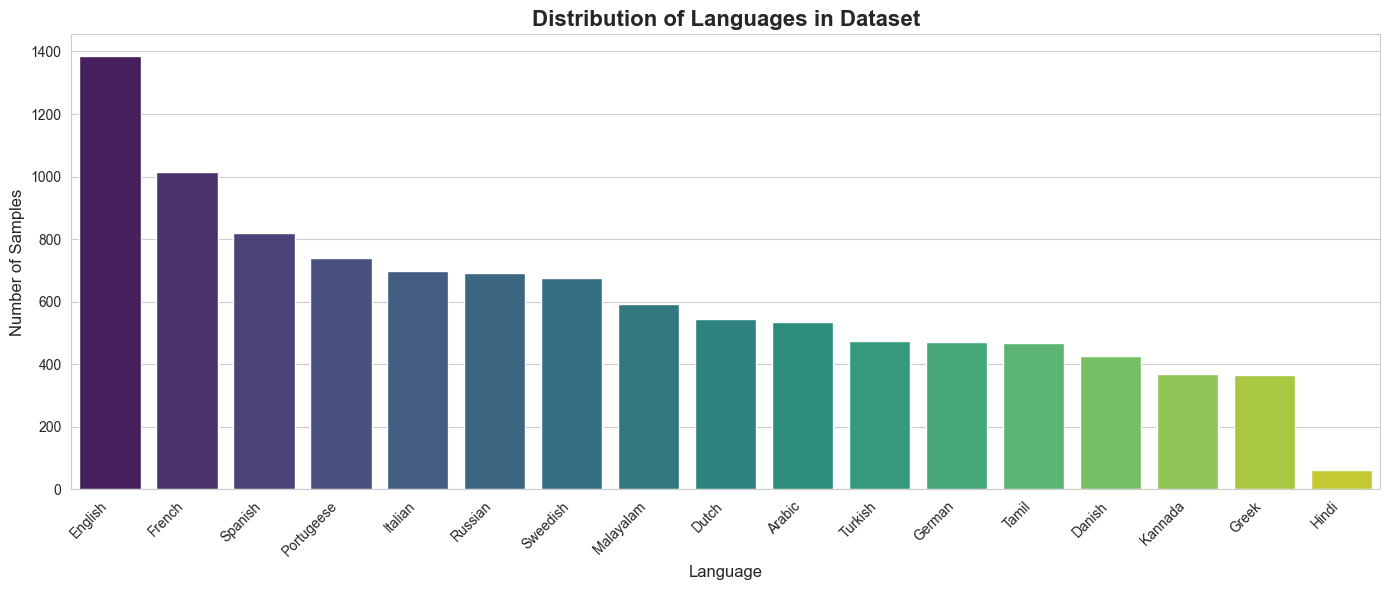

Language distribution:
Language
English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           63
Name: count, dtype: int64


In [4]:
# Distribution of languages
language_counts = df['Language'].value_counts()

plt.figure(figsize=(14, 6))
sns.barplot(x=language_counts.index, y=language_counts.values, palette='viridis')
plt.title('Distribution of Languages in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Language', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Language distribution:")
print(language_counts)


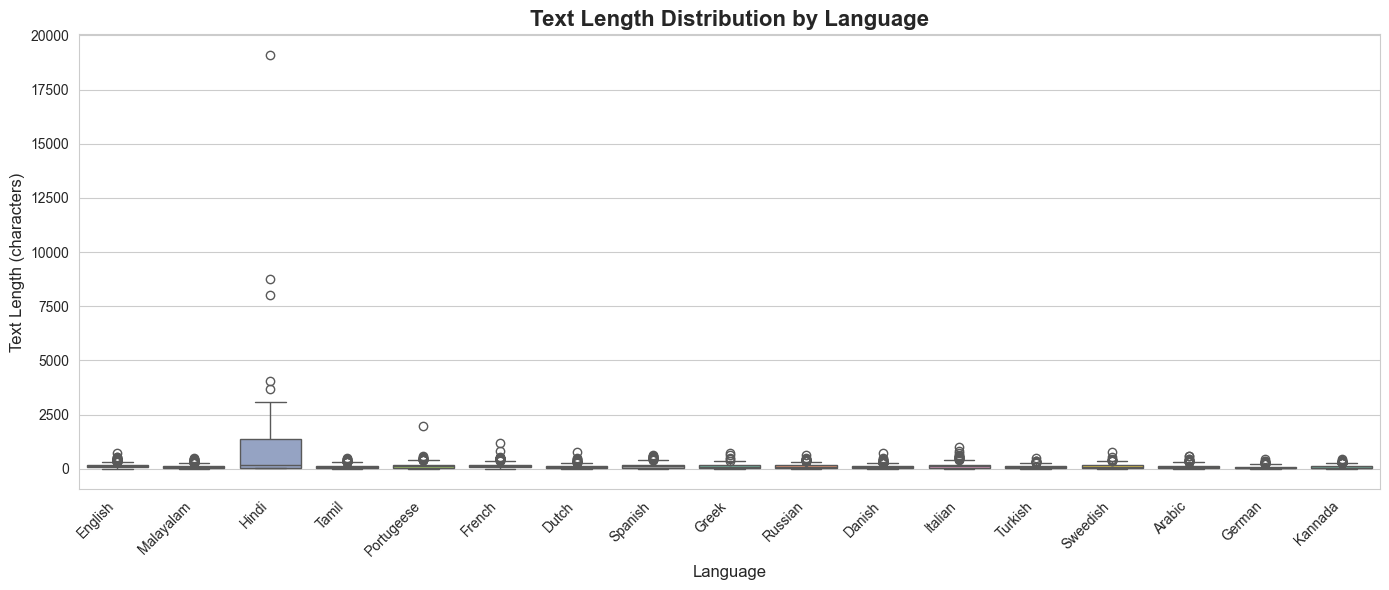


Text Length Statistics:
             count         mean          std   min    25%    50%      75%  \
Language                                                                    
Arabic       536.0    99.192164    81.205879   1.0  37.00   80.0   141.00   
Danish       428.0    91.252336    87.122148   3.0  28.00   68.0   121.25   
Dutch        546.0    99.263736    85.088880   7.0  32.00   84.0   132.75   
English     1385.0   136.901083    83.397663   5.0  81.00  124.0   180.00   
French      1014.0   145.135108   103.826981   5.0  75.00  132.0   194.75   
German       470.0    74.702128    62.773500   6.0  28.00   56.0   105.00   
Greek        365.0   106.260274    97.078991   5.0  28.00   87.0   157.00   
Hindi         63.0  1209.190476  2833.621790  15.0  45.50  189.0  1376.50   
Italian      698.0   142.157593   117.033151   4.0  48.25  121.5   196.00   
Kannada      369.0    87.696477    79.065019   5.0  29.00   58.0   118.00   
Malayalam    594.0    99.735690    78.839384   5.0 

In [5]:
# Analyze text length distribution
df['Text_Length'] = df['Text'].apply(len)

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Language', y='Text_Length', palette='Set2')
plt.title('Text Length Distribution by Language', fontsize=16, fontweight='bold')
plt.xlabel('Language', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary statistics
print("\nText Length Statistics:")
print(df.groupby('Language')['Text_Length'].describe())


## 4. Data Preprocessing


In [6]:
def preprocess_text(text):
    """
    Clean and preprocess text data:
    - Convert to lowercase
    - Remove special characters and numbers
    - Keep only letters and spaces
    
    NOTE: This version removes non-Latin characters, which causes issues with
    languages like Hindi, Arabic, Japanese, etc. For better support of non-Latin
    scripts, use preprocess_text_unicode() instead.
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and extra spaces
    # Keep only letters and spaces (Latin alphabet only)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_text_unicode(text):
    """
    Improved preprocessing that preserves Unicode characters (non-Latin scripts).
    This version works better for languages like Hindi, Arabic, Japanese, etc.
    
    Clean and preprocess text data:
    - Convert to lowercase
    - Remove punctuation and numbers (but keep Unicode letters)
    - Keep letters from all scripts (Latin, Arabic, Devanagari, etc.) and spaces
    
    Note: To use this, you'll need to retrain the model with this preprocessing.
    """
    import unicodedata
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and numbers, but keep Unicode letters
    # This preserves characters from all scripts (Latin, Arabic, Devanagari, etc.)
    # We keep characters that are Unicode letters (category starts with 'L')
    cleaned_chars = []
    for char in text:
        # Keep letters (any Unicode letter) and whitespace
        if unicodedata.category(char).startswith('L') or char.isspace():
            cleaned_chars.append(char)
    
    text = ''.join(cleaned_chars)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing
df['Text_Cleaned'] = df['Text'].apply(preprocess_text)

# Display sample before and after preprocessing
print("Sample preprocessing:")
print("Original:", df['Text'].iloc[0])
print("Cleaned:", df['Text_Cleaned'].iloc[0])

# Check for empty texts after preprocessing
empty_texts = df[df['Text_Cleaned'].str.len() == 0]
print(f"\nEmpty texts after preprocessing: {len(empty_texts)}")

# Show some examples of texts that became empty (likely non-Latin scripts)
if len(empty_texts) > 0:
    print("\n⚠️ NOTE: Many empty texts are likely from non-Latin scripts (Hindi, Arabic, etc.)")
    print("The current preprocessing removes non-Latin characters, which affects these languages.")
    print("Sample of texts that became empty:")
    for idx in empty_texts.head(3).index:
        print(f"  Original: {df.loc[idx, 'Text'][:50]}...")
        print(f"  Language: {df.loc[idx, 'Language']}")
    print("\n💡 TIP: For better non-Latin script support, use preprocess_text_unicode() and retrain the model.")

# Remove empty texts if any
if len(empty_texts) > 0:
    df = df[df['Text_Cleaned'].str.len() > 0].reset_index(drop=True)
    print(f"\nRemoved {len(empty_texts)} empty texts")


Sample preprocessing:
Original:  Nature, in the broadest sense, is the natural, physical, material world or universe.
Cleaned: nature in the broadest sense is the natural physical material world or universe

Empty texts after preprocessing: 2847

⚠️ NOTE: Many empty texts are likely from non-Latin scripts (Hindi, Arabic, etc.)
The current preprocessing removes non-Latin characters, which affects these languages.
Sample of texts that became empty:
  Original: ഭൗതികപ്രതിഭാസങ്ങളും ജീവനും പ്രകൃതിയുടെ ഘടകങ്ങളാണ്....
  Language: Malayalam
  Original: മനുഷ്യനിർമിതമായ വസ്തുക്കളെ പ്രകൃതിയുടെ ഭാഗമായി കണക...
  Language: Malayalam
  Original: പ്രകൃതി എന്ന പദം പ്രപഞ്ചത്തെയും അതിലെ സമസ്ത പ്രതിഭ...
  Language: Malayalam

💡 TIP: For better non-Latin script support, use preprocess_text_unicode() and retrain the model.

Removed 2847 empty texts


### ⚠️ Important Note on Preprocessing

The current preprocessing function (`preprocess_text`) removes all non-Latin characters, which means:
- **Works well for**: English, French, Spanish, German, Italian, Portuguese, etc. (Latin scripts)
- **Limited support for**: Hindi, Arabic, Tamil, Kannada, Malayalam, etc. (non-Latin scripts)

If you want better support for non-Latin scripts, you can:
1. Use `preprocess_text_unicode()` instead (defined above)
2. Retrain the model with the Unicode-aware preprocessing
3. This will preserve characters from all scripts and improve detection for non-Latin languages

**Current model performance**: ~93% accuracy overall, but lower for languages with few samples or non-Latin scripts.


In [7]:
# Initialize label encoder
label_encoder = LabelEncoder()

# Encode language labels
df['Language_Encoded'] = label_encoder.fit_transform(df['Language'])

# Create mapping dictionary for reference
language_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Language to Encoded Value Mapping:")
for lang, encoded in sorted(language_mapping.items(), key=lambda x: x[1]):
    print(f"{lang}: {encoded}")

# Store the label encoder for later use in predictions
print(f"\nTotal languages: {len(label_encoder.classes_)}")


Language to Encoded Value Mapping:
Arabic: 0
Danish: 1
Dutch: 2
English: 3
French: 4
German: 5
Greek: 6
Hindi: 7
Italian: 8
Kannada: 9
Malayalam: 10
Portugeese: 11
Russian: 12
Spanish: 13
Sweedish: 14
Tamil: 15
Turkish: 16

Total languages: 17


## 6. Feature Engineering - Bag of Words


In [8]:
# Prepare features and target
X = df['Text_Cleaned']
y = df['Language_Encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set distribution:\n{y_train.value_counts().sort_index()}")


Training set size: 5992
Test set size: 1498
Training set distribution:
Language_Encoded
0       31
1      343
2      437
3     1108
4      811
5      376
6       32
7       11
8      558
9       11
10      21
11     591
12      81
13     654
14     541
15       7
16     379
Name: count, dtype: int64


In [9]:
# Initialize CountVectorizer (Bag of Words)
count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform training data
X_train_bow = count_vectorizer.fit_transform(X_train)

# Transform test data
X_test_bow = count_vectorizer.transform(X_test)

print(f"Feature matrix shape (training): {X_train_bow.shape}")
print(f"Feature matrix shape (test): {X_test_bow.shape}")
print(f"\nNumber of features (vocabulary size): {len(count_vectorizer.vocabulary_)}")


Feature matrix shape (training): (5992, 5000)
Feature matrix shape (test): (1498, 5000)

Number of features (vocabulary size): 5000


## 7. Model Training - Multinomial Naive Bayes


In [10]:
# Initialize and train Multinomial Naive Bayes model
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_bow, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test_bow)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)

print(f"Multinomial Naive Bayes Accuracy: {accuracy_nb:.4f} ({accuracy_nb*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))


Multinomial Naive Bayes Accuracy: 0.9299 (92.99%)

Classification Report:
              precision    recall  f1-score   support

      Arabic       0.00      0.00      0.00         8
      Danish       0.99      0.91      0.94        85
       Dutch       0.99      0.94      0.97       109
     English       0.80      0.99      0.88       277
      French       0.96      0.98      0.97       203
      German       0.99      0.97      0.98        94
       Greek       0.00      0.00      0.00         8
       Hindi       0.00      0.00      0.00         2
     Italian       0.99      0.97      0.98       140
     Kannada       0.00      0.00      0.00         3
   Malayalam       0.00      0.00      0.00         5
  Portugeese       0.97      0.95      0.96       148
     Russian       1.00      0.10      0.18        20
     Spanish       0.96      0.95      0.96       164
    Sweedish       0.94      0.98      0.96       135
       Tamil       0.00      0.00      0.00         2
     Tu

## 8. Model Evaluation - Confusion Matrix


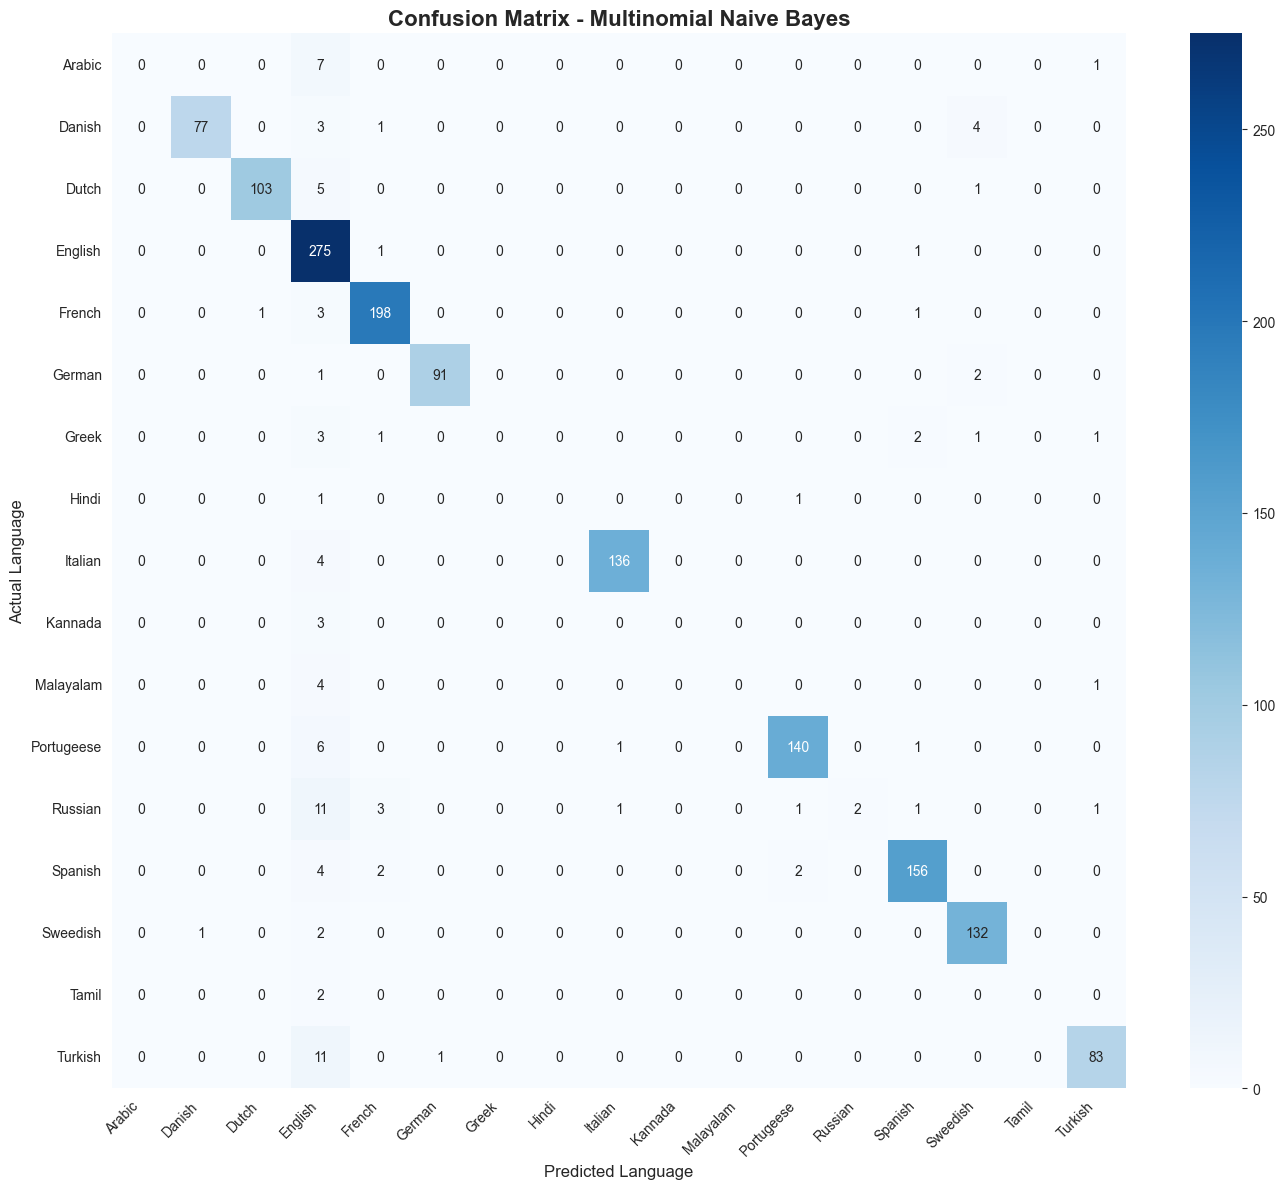

In [11]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)

# Visualize confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Multinomial Naive Bayes', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Language', fontsize=12)
plt.ylabel('Actual Language', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 9. Experimenting with TF-IDF Vectorization


In [12]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train model with TF-IDF features
nb_model_tfidf = MultinomialNB(alpha=1.0)
nb_model_tfidf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_tfidf = nb_model_tfidf.predict(X_test_tfidf)

# Calculate accuracy
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

print(f"Multinomial Naive Bayes with TF-IDF Accuracy: {accuracy_tfidf:.4f} ({accuracy_tfidf*100:.2f}%)")

# Compare with Bag of Words
print(f"\nComparison:")
print(f"Bag of Words: {accuracy_nb:.4f} ({accuracy_nb*100:.2f}%)")
print(f"TF-IDF: {accuracy_tfidf:.4f} ({accuracy_tfidf*100:.2f}%)")


Multinomial Naive Bayes with TF-IDF Accuracy: 0.9286 (92.86%)

Comparison:
Bag of Words: 0.9299 (92.99%)
TF-IDF: 0.9286 (92.86%)


Training and evaluating different classifiers with Bag of Words:

MultinomialNB: 0.9299 (92.99%)


LogisticRegression: 0.9146 (91.46%)


SVM: 0.8825 (88.25%)


RandomForest: 0.8979 (89.79%)


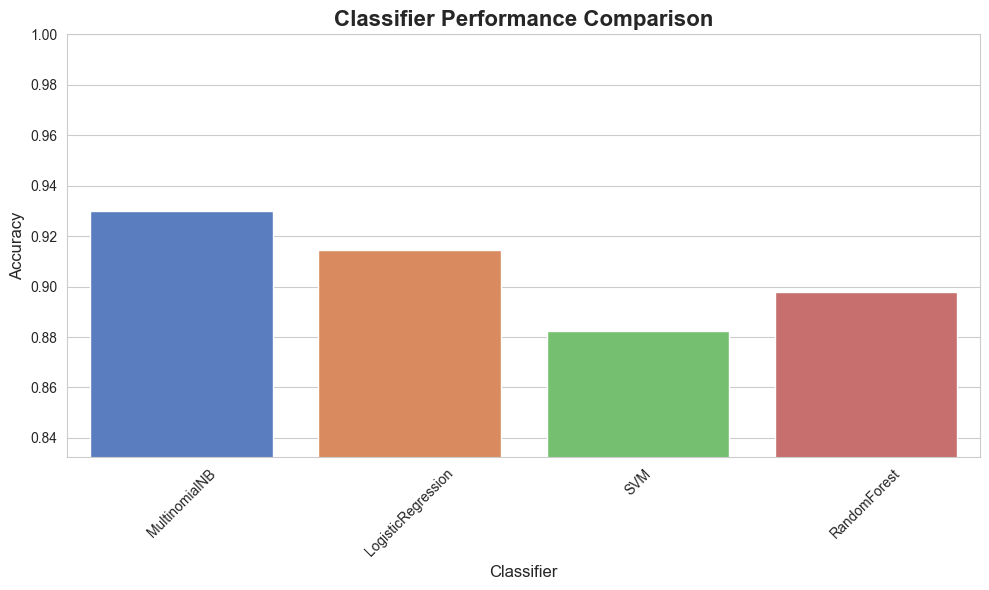

In [13]:
# Dictionary to store results
results = {}

# Test different classifiers with Bag of Words
classifiers = {
    'MultinomialNB': MultinomialNB(alpha=1.0),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

print("Training and evaluating different classifiers with Bag of Words:\n")

for name, classifier in classifiers.items():
    # Train model
    classifier.fit(X_train_bow, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test_bow)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"{name}: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Visualize comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='muted')
plt.title('Classifier Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Classifier', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([min(results.values()) - 0.05, 1.0])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
def predict_language(text, model, vectorizer, label_encoder):
    """
    Predict the language of a given text.
    
    Parameters:
    -----------
    text : str
        Input text to predict language for
    model : sklearn model
        Trained classification model
    vectorizer : sklearn vectorizer
        Fitted vectorizer (CountVectorizer or TfidfVectorizer)
    label_encoder : sklearn LabelEncoder
        Fitted label encoder
    
    Returns:
    --------
    str : Predicted language
    float : Prediction probability
    """
    # Preprocess the text
    cleaned_text = preprocess_text(text)
    
    # Transform text to features
    text_vectorized = vectorizer.transform([cleaned_text])
    
    # Predict
    prediction_encoded = model.predict(text_vectorized)[0]
    prediction_proba = model.predict_proba(text_vectorized)[0]
    
    # Decode prediction
    predicted_language = label_encoder.inverse_transform([prediction_encoded])[0]
    confidence = max(prediction_proba)
    
    return predicted_language, confidence

# Test the prediction function with sample texts
test_texts = [
    "Hello, how are you today?",
    "Bonjour, comment allez-vous?",
    "Hola, ¿cómo estás?",
    "Guten Tag, wie geht es dir?",
    "Ciao, come stai?",
    "नमस्ते, आप कैसे हैं?",
    "こんにちは、元気ですか？",
    "مرحبا، كيف حالك؟"
]

print("Language Prediction Results:\n")
print("-" * 60)
for text in test_texts:
    predicted_lang, confidence = predict_language(text, nb_model, count_vectorizer, label_encoder)
    print(f"Text: {text[:50]}...")
    print(f"Predicted Language: {predicted_lang}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print("-" * 60)


Language Prediction Results:

------------------------------------------------------------
Text: Hello, how are you today?...
Predicted Language: English
Confidence: 1.0000 (100.00%)
------------------------------------------------------------
Text: Bonjour, comment allez-vous?...
Predicted Language: French
Confidence: 0.5421 (54.21%)
------------------------------------------------------------
Text: Hola, ¿cómo estás?...
Predicted Language: Spanish
Confidence: 0.9504 (95.04%)
------------------------------------------------------------
Text: Guten Tag, wie geht es dir?...
Predicted Language: German
Confidence: 1.0000 (100.00%)
------------------------------------------------------------
Text: Ciao, come stai?...
Predicted Language: Italian
Confidence: 0.9696 (96.96%)
------------------------------------------------------------
Text: नमस्ते, आप कैसे हैं?...
Predicted Language: English
Confidence: 0.1849 (18.49%)
------------------------------------------------------------
Text: こんにちは、元

In [15]:
# Save the best model and vectorizers
joblib.dump(nb_model, 'language_detection_model.pkl')
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Model and vectorizers saved successfully!")
print("Files created:")
print("- language_detection_model.pkl")
print("- count_vectorizer.pkl")
print("- tfidf_vectorizer.pkl")
print("- label_encoder.pkl")


Model and vectorizers saved successfully!
Files created:
- language_detection_model.pkl
- count_vectorizer.pkl
- tfidf_vectorizer.pkl
- label_encoder.pkl
